# **Name** - Manu Mathew
# **StudentID** - 8990691

**Objective** - The primary objective of the Lab is to build and compare image classification model that can accurately distinguish the images of cats and dogs. In this notebook, 
- We first prepare a manageable dataset of 5000 images where 2500 images are of dogs and 2500 images are of cats.
- Then we perform the exploratory data analysis (EDA) to understand the dataset characteristics and identify data quality issues.
- Train and evaluate two deep learning models:
    - A custom-defined Convolutional Neural Network (CNN).
    - A fine-tuned VGG16 model pre-trained on ImageNet.
- Explore the relative performance of the models.

`Approach`: 
- Data:
    Use 5000 images from Kaggle and organize them into train/test folders.

- Preprocessing:
    Resize images, normalize pixel values, apply data augmentation, and split into train/validation/test sets.

- EDA:
    Visualize sample images, check class distribution, and analyze pixel intensity.

- Model 1 - Custom CNN:
    Build and train a basic CNN with conv, pooling, and dense layers using binary classification.

- Model 2 - Fine-Tune VGG16:
    Load pre-trained VGG16 (without top), freeze base, add custom top layers, and train with the same data.

- Evaluation:
    Compare both models using accuracy, confusion matrix, precision, recall, F1-score, and PR curve.

- Error Analysis:
    Show and review misclassified images to find patterns in errors.

- Conclusion:
    Summarize which model performed better and suggest possible improvements.

## **Import the dependencies**

In [71]:
import os, shutil, pathlib
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import random
import numpy as np

## **Obtain the dataset (data preparation)**

In the below block of code , we have the original set of images 25000 in the train folder. Create a small dataset of 1000 training images, 500 validation images and 1000 test images per class. This reduces the dataset from 25,000 images to 5000.

In [46]:
# orginal_dir is the directory where the original dataset is stored.
original_dir = pathlib.Path("./data/train")
# new_base_dir is the directory where the new dataset structure will be created.
# It will contain subdirectories for train, validation, and test sets.
new_base_dir = pathlib.Path("./data/kaggle_dogs_vs_cats_small")

# Create the new base directory if it doesn't exist
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

# Create train, validation, and test subsets
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## **EDA: Explore the data with relevant graphs, statistics and insights** 

In [47]:
# Set the path to the  dataset
data_folder = pathlib.Path('./data/kaggle_dogs_vs_cats_small')

In [48]:
# Load the datasets using image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [49]:
type(train_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

### **Displaying the shapes of the data and labels yielded by the `Dataset`:**

In [50]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [51]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0], dtype=int32)>

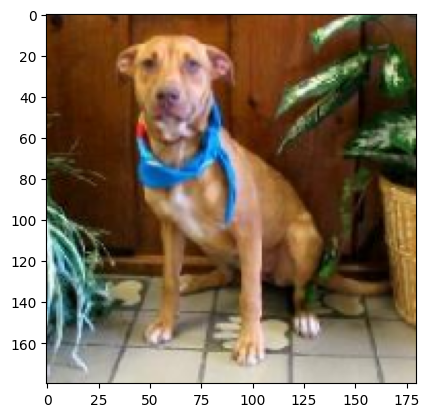

In [52]:
plt.imshow(data_batch[0].numpy().astype("uint8"))

**Visualizing images**

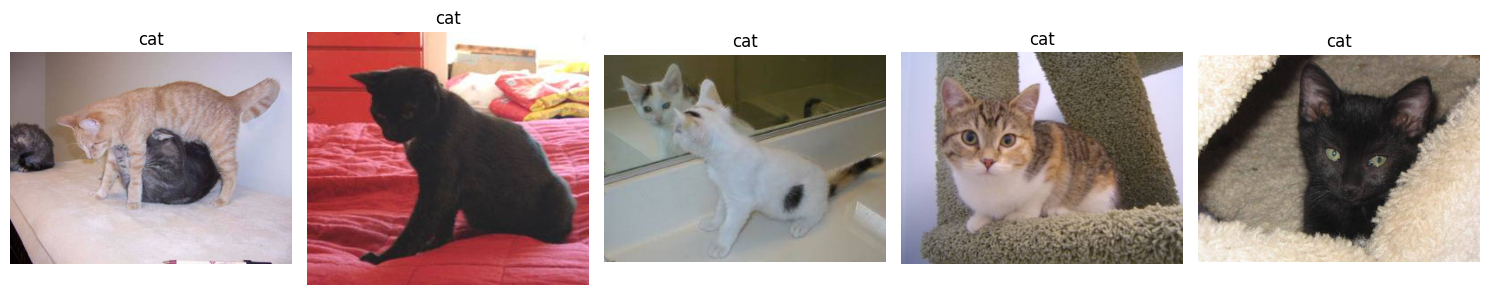

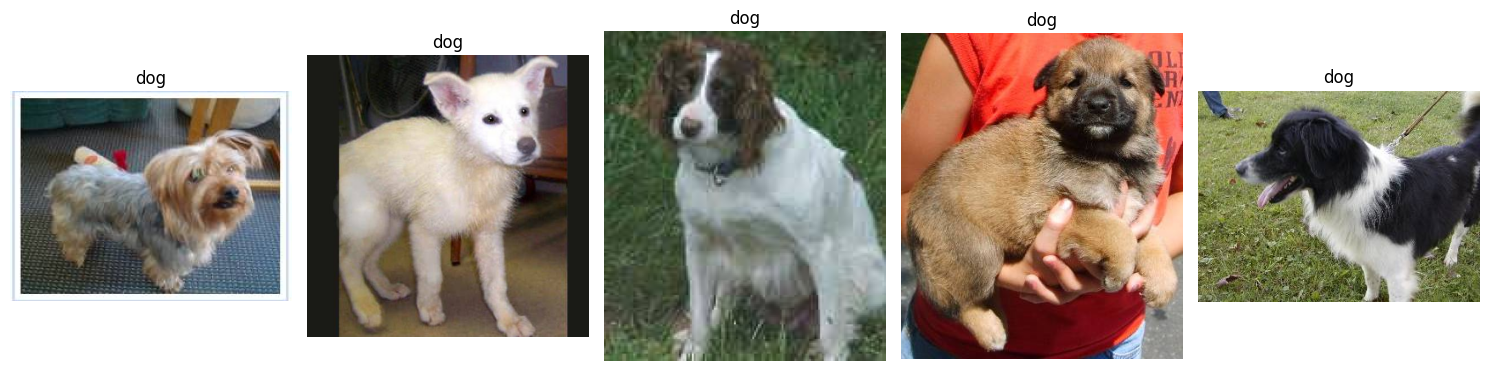

In [53]:
# Preview random 5 images from each class in train set
def plot_sample_images(directory, label, n=5):
    path = os.path.join(directory, label)
    images = random.sample(os.listdir(path), n)
    fig, axes = plt.subplots(1, n, figsize=(15,5))
    for img_name, ax in zip(images, axes):
        img_path = os.path.join(path, img_name)
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.tight_layout()

plot_sample_images('./data/kaggle_dogs_vs_cats_small/train', 'cat')
plot_sample_images('./data/kaggle_dogs_vs_cats_small/train', 'dog')

### **EDA Insights:**
- Dataset contains equal number of `cat` and `dog` images across train, validation, and test sets.
- All images are RGB and of varying resolutions.
- This balanced setup avoids class imbalance issues during training.


## **Model 1 – Custom Convolutional Neural Network (CNN)**

#### **4.1 Model Design**

In [54]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Next I display the model summary

In [55]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training**

In [57]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/cnn.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 421ms/step - accuracy: 0.4979 - loss: 0.7106 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - accuracy: 0.5279 - loss: 0.6895 - val_accuracy: 0.5770 - val_loss: 0.6888
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 423ms/step - accuracy: 0.5250 - loss: 0.6866 - val_accuracy: 0.5350 - val_loss: 0.6843
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 398ms/step - accuracy: 0.6077 - loss: 0.6696 - val_accuracy: 0.5930 - val_loss: 0.6600
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 393ms/step - accuracy: 0.6385 - loss: 0.6361 - val_accuracy: 0.5720 - val_loss: 0.8027
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 383ms/step - accuracy: 0.6585 - loss: 0.6329 - val_accuracy: 0.6820 - val_loss: 0.5789
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 394ms/step - accuracy: 0.6790 - loss: 0.5786 - val_accuracy: 0.6880 - val_loss: 0.5929
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 378ms/step - accuracy: 0.7033 - loss: 0.5686 - val_accu

**Learning Curves**

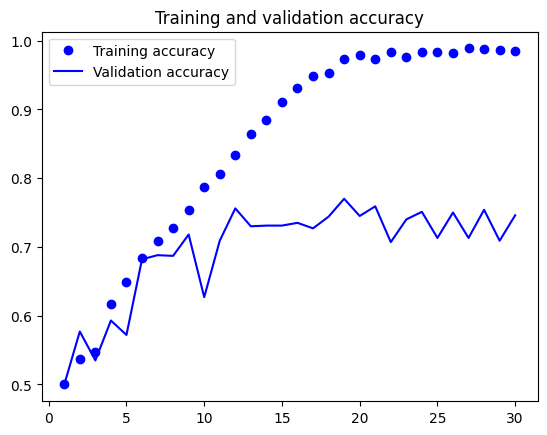

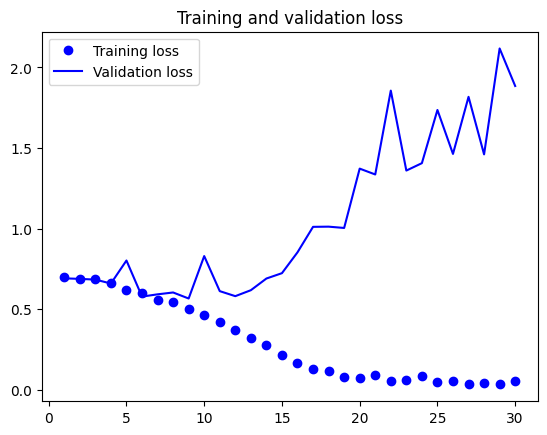

In [58]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Overfitting is evident, around epoch 12.

In [60]:
test_model = keras.models.load_model("./models/cnn.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.7323 - loss: 0.5805
Test accuracy: 0.738


#### **Transfer Learning (VGG16 Fine-Tuning)**

In [ ]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(180, 180, 3))
conv_base.trainable = False  # Freeze for initial training

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


**Model Construction**

In [64]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vgg_model = keras.Model(inputs, outputs)
vgg_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

The summary about the model is:

In [65]:
vgg_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 180, 180,  │          0 │ input_layer_8[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 180, 180,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 180, 180,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 12800)     │          0 │ vgg16[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        257 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Feature extraction**

In [72]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [75]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [76]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [77]:
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,277,313 (12.50 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

**Training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/vgg16_finetune_best.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8813 - loss: 21.5445 - val_accuracy: 0.9650 - val_loss: 4.8595
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9754 - loss: 2.6673 - val_accuracy: 0.9670 - val_loss: 6.9975
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9862 - loss: 1.4867 - val_accuracy: 0.9700 - val_loss: 5.0828
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9883 - loss: 1.3841 - val_accuracy: 0.9750 - val_loss: 4.5186
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9963 - loss: 0.7623 - val_accuracy: 0.9720 - val_loss: 4.6442
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9931 - loss: 0.4672 - val_accuracy: 0.9740 - val_loss: 5.1877
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9915 - loss: 1.1451 - val_accuracy: 0.9750 - val_loss: 5.4945
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9967 - loss: 0.2980 - val_accuracy: 0.9720 - 

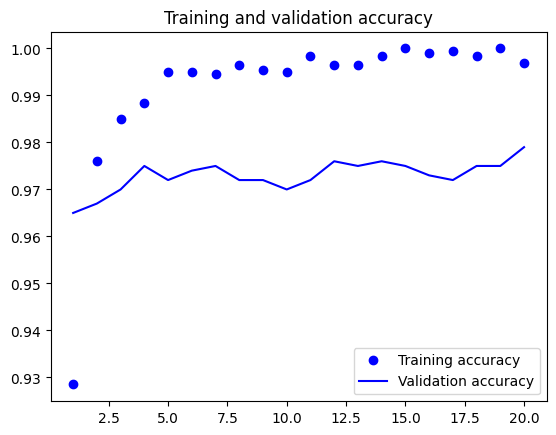

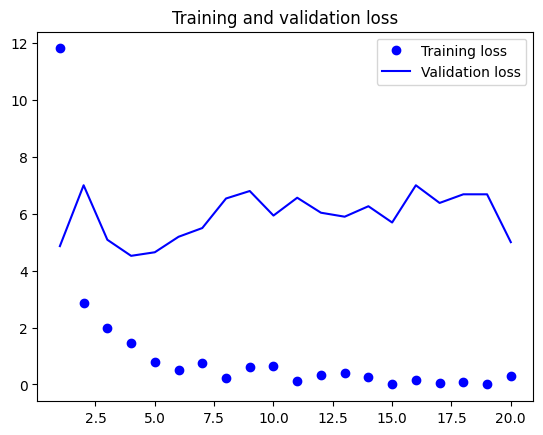

In [79]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [80]:
test_model = keras.models.load_model(
    "./models/vgg16_finetune_best.keras")
test_loss, test_acc = test_model.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9732 - loss: 4.5772
Test accuracy: 0.970


**Fine-Tuning the pretrained model**

In [81]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

**Fine-tuning the model**

In [94]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

vgg_model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(1e-5), metrics=["accuracy"])

# Continue training for a few epochs to fine-tune
history_fine = vgg_model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9765 - loss: 0.0581 - val_accuracy: 0.9850 - val_loss: 0.0603
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9884 - loss: 0.0282 - val_accuracy: 0.9870 - val_loss: 0.0573
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9900 - loss: 0.0343 - val_accuracy: 0.9850 - val_loss: 0.0611
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.9918 - loss: 0.0265 - val_accuracy: 0.9820 - val_loss: 0.0789
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9894 - loss: 0.0357 - val_accuracy: 0.9850 - val_loss: 0.0721
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9939 - loss: 0.0212 - val_accuracy: 0.9820 - val_loss: 0.0833
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.9856 - loss: 0.0361 - val_accuracy: 0.9840 - val_loss: 0.0783
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9916 - loss: 0.0177 - val_accuracy: 0.9840 - v

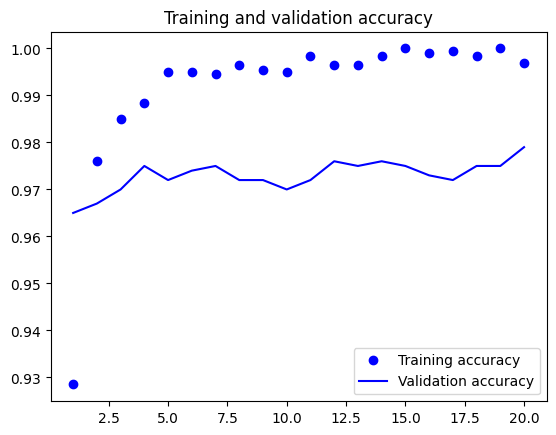

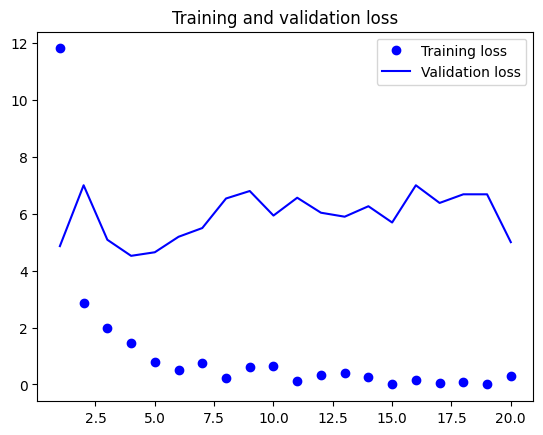

In [95]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Overfitting was evident, around epoch 12

In [96]:

model = keras.models.load_model("./models/vgg16_finetune_best.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9821 - loss: 0.0670
Test accuracy: 0.979
